## Explanatory Data analysis

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd

from ipywidgets import Dropdown, VBox, Output
from IPython.display import display

In [65]:
# Paths 2020 and 2024
csv_path2020_euroSciVoc = "../data/cordis-h2020projects-csv/euroSciVoc.csv"
csv_path2020_organization = "../data/cordis-h2020projects-csv/organization.csv"
csv_path2020_publication_citation = "../data/cordis-h2020projects-csv/updated_publications_with_citations_2020.csv"

csv_path2024_euroSciVoc = "../data/cordis-HORIZONprojects-csv/euroSciVoc.csv"
csv_path2024_organization = "../data/cordis-HORIZONprojects-csv/organization.csv"
csv_path2024_publication_citation = "../data/cordis-HORIZONprojects-csv/updated_publications_with_citations_2024.csv"


In [66]:
## for horizon 2020 MISSING VALUES AND DUPLICATES

# Dataframes inlezen
df2020_euroSciVoc = pd.read_csv(csv_path2020_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_organization = pd.read_csv(csv_path2020_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_publication_citation = pd.read_csv(csv_path2020_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# euroSciVoc
print("=== euroSciVoc ===")
print("Missing values:\n", df2020_euroSciVoc.isnull().sum())
print("Duplicated rows:", df2020_euroSciVoc.duplicated().sum(), "\n")

# organization
print("=== organization ===")
print("Missing values:\n", df2020_organization.isnull().sum())
print("Duplicated rows:", df2020_organization.duplicated().sum(), "\n")

# publications citation
print("=== publications citation ===")
print("Missing values:\n", df2020_publication_citation.isnull().sum())
print("Duplicated rows:", df2020_publication_citation.duplicated().sum(), "\n")

## duplicates verwijderen, we hebben hier geen meerwaarde aan 
## bepaalde rijen waar gegevens ontbreken, verwijderen we ook. bv waar projectID, title, startdate, enddate, maxEcContribution, EcContribution, role, country ontbreekt 

# ORGANIZATION — nodig voor funding en coördinatierollen per land
df2020_organization.drop_duplicates(inplace=True)
df2020_organization.dropna(subset=["projectID", "organisationID", "role", "country", "ecContribution"], inplace=True)

# EUROSCIVOC — nodig om projecten aan categorieën te koppelen
df2020_euroSciVoc.drop_duplicates(inplace=True)
df2020_euroSciVoc.dropna(subset=["projectID"], inplace=True)

# PUBLICATIONS CITATION
df2020_publication_citation.drop_duplicates(inplace=True)
df2020_publication_citation.dropna(subset=["doi", "title", "publishedYear", "citation_count"], inplace=True)

=== euroSciVoc ===
Missing values:
 projectID                     0
euroSciVocCode                0
euroSciVocPath                0
euroSciVocTitle               0
euroSciVocDescription    114193
dtype: int64
Duplicated rows: 0 

=== organization ===
Missing values:
 projectID                  0
projectAcronym             0
organisationID             0
vatNumber              23528
name                       0
shortName              40141
SME                      516
activityType             954
street                  1209
postCode                1986
city                     522
country                  264
nutsCode                 618
geolocation              232
organizationURL        62539
contactForm                0
contentUpdateDate          0
rcn                        0
order                      0
role                       0
ecContribution          7769
netEcContribution         37
totalCost                187
endOfParticipation         0
active                176558
dtype: 

In [67]:
## for horizon 2024
# Dataframes inlezen
df2024_euroSciVoc = pd.read_csv(csv_path2024_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_organization = pd.read_csv(csv_path2024_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_publication_citation = pd.read_csv(csv_path2024_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# euroSciVoc
print("=== euroSciVoc ===")
print("Missing values:\n", df2024_euroSciVoc.isnull().sum())
print("Duplicated rows:", df2024_euroSciVoc.duplicated().sum(), "\n")

# organization
print("=== organization ===")
print("Missing values:\n", df2024_organization.isnull().sum())
print("Duplicated rows:", df2024_organization.duplicated().sum(), "\n")

# publications citation
print("=== publications citation ===")
print("Missing values:\n", df2024_publication_citation.isnull().sum())
print("Duplicated rows:", df2024_publication_citation.duplicated().sum(), "\n")

## duplicates verwijderen, we hebben hier geen meerwaarde aan 
## bepaalde rijen waar gegevens ontbreken, verwijderen we ook. bv waar projectID, title, startdate, enddate, maxEcContribution, EcContribution, role, country ontbreekt 

# ORGANIZATION — nodig voor funding en coördinatierollen per land
df2024_organization.drop_duplicates(inplace=True)
df2024_organization.dropna(subset=["projectID", "organisationID", "role", "country", "ecContribution"], inplace=True)

# EUROSCIVOC — nodig om projecten aan categorieën te koppelen
df2024_euroSciVoc.drop_duplicates(inplace=True)
df2024_euroSciVoc.dropna(subset=["projectID"], inplace=True)

# PUBLICATIONS CITATION
df2024_publication_citation.drop_duplicates(inplace=True)
df2024_publication_citation.dropna(subset=["doi", "title", "publishedYear", "citation_count"], inplace=True)


=== euroSciVoc ===
Missing values:
 projectID                    0
euroSciVocCode               0
euroSciVocPath               0
euroSciVocTitle              0
euroSciVocDescription    38789
dtype: int64
Duplicated rows: 0 

=== organization ===
Missing values:
 projectID                  0
projectAcronym             0
organisationID             0
vatNumber              15403
name                       0
shortName              25507
SME                      263
activityType              24
street                   300
postCode                 786
city                     263
country                   13
nutsCode                 278
geolocation              588
organizationURL        38954
contactForm                0
contentUpdateDate          0
rcn                        0
order                      0
role                       0
ecContribution         15704
netEcContribution         42
totalCost                936
endOfParticipation         0
active                100249
dtype: int64

In [68]:
# Add a 'source' column to each dataframe before concatenation

# ORGANIZATION — funding and coordinator roles per country
df2020_organization['source'] = '2020'
df2024_organization['source'] = '2024'
df_organization = pd.concat([df2020_organization, df2024_organization], ignore_index=True)

# EUROSCIVOC — linking projects to categories
df2020_euroSciVoc['source'] = '2020'
df2024_euroSciVoc['source'] = '2024'
df_euroSciVoc = pd.concat([df2020_euroSciVoc, df2024_euroSciVoc], ignore_index=True)

# PUBLICATION CITATION — citation data for publications
df2020_publication_citation['source'] = '2020'
df2024_publication_citation['source'] = '2024'
df_publication_citation = pd.concat([df2020_publication_citation.drop_duplicates(), df2024_publication_citation.drop_duplicates()], ignore_index=True)

# (Optional) Print shapes to confirm
print("df_organization shape:", df_organization.shape)
print("df_euroSciVoc shape:", df_euroSciVoc.shape)
print("df_publication_citation shape:", df_publication_citation.shape)

df_organization shape: (254699, 26)
df_euroSciVoc shape: (152982, 6)
df_publication_citation shape: (377887, 18)


In [69]:
# Extract category from the concatenated dataframe
df_euroSciVoc['category'] = df_euroSciVoc['euroSciVocPath'].str.split('/').str[1]

df_publication_citation['projectID'] = pd.to_numeric(df_publication_citation['projectID'], errors='coerce')
df_euroSciVoc['projectID'] = df_euroSciVoc['projectID']
# Merge publications with project categories
df_pubs_cat = pd.merge(df_publication_citation, df_euroSciVoc[['projectID', 'category']], on='projectID', how='left')

# Use publishedYear as 'Year'
df_pubs_cat['Year'] = pd.to_numeric(df_pubs_cat['publishedYear'], errors='coerce').astype('Int64')

# Prepare data: count publications and sum citations per category per year
category_year_stats = (
    df_pubs_cat
    .groupby(['category', 'Year'])
    .agg(
        publication_count=('id', 'count'),
        total_citations=('citation_count', 'sum')
    )
    .reset_index()
)

# Prepare data: sum citations per category per year
citations_per_topic_year = (
    df_pubs_cat
    .groupby(['Year', 'category'])
    .agg(total_citations=('citation_count', 'sum'))
    .reset_index()
)

In [70]:
# Optional: add a 'Year' column for convenience
df_pubs_cat['Year'] = pd.to_numeric(df_pubs_cat['publishedYear'], errors='coerce').astype('Int64')

# Filter valid citation counts
df_pubs_cat_valid = df_pubs_cat[(df_pubs_cat['citation_count'].notna()) & (df_pubs_cat['citation_count'] != -1)]

# Print how many are not valid
n_invalid = len(df_pubs_cat) - len(df_pubs_cat_valid)
print(f"Number of rows with invalid citation_count (NA or -1): {n_invalid}")


# 1. Aggregate total citations per project
project_citations = (
    df_pubs_cat_valid.groupby('projectID')
    .agg(total_citations=('citation_count', 'sum'))
    .reset_index()
)

# 2. Get funding, coordinator country, and research category for each project
# Funding: sum ecContribution per project
project_funding = (
    df_organization.groupby('projectID')['ecContribution'].sum().reset_index()
)

# Coordinator country: take the country where role == 'coordinator'
coordinator_country = (
    df_organization[df_organization['role'].str.lower() == 'coordinator']
    .groupby('projectID')['country'].first().reset_index()
)

# Research category: take the first category for each project
project_category = (
    df_euroSciVoc.groupby('projectID')['category'].first().reset_index()
)

# Years since publication (as of 28.06.2023)
dataset_update_date = datetime(2023, 6, 28)
project_year = (
    df_pubs_cat.groupby('projectID')['publishedYear']
    .min()
    .reset_index()
    .rename(columns={'publishedYear': 'first_publication_year'})
)
project_year['projectID'] = project_year['projectID'].astype(str)
project_year['first_publication_year'] = pd.to_numeric(project_year['first_publication_year'], errors='coerce')
project_year['years_since_publication'] = (
    dataset_update_date.year - project_year['first_publication_year']
).astype('Float64')

# Ensure projectID is string in all relevant DataFrames
project_citations['projectID'] = project_citations['projectID'].astype(str)
project_funding['projectID'] = project_funding['projectID'].astype(str)
coordinator_country['projectID'] = coordinator_country['projectID'].astype(str)
project_category['projectID'] = project_category['projectID'].astype(str)

# Merge all features
df_reg = project_citations.merge(project_funding, on='projectID', how='left') \
    .merge(coordinator_country, on='projectID', how='left') \
    .merge(project_category, on='projectID', how='left') \
    .merge(project_year[['projectID', 'years_since_publication']], on='projectID', how='left')

# Drop rows with missing values in any explanatory variable
df_reg = df_reg.dropna(subset=['ecContribution', 'country', 'category', 'total_citations', 'years_since_publication'])
df_reg = df_reg[df_reg['years_since_publication'] >= 0]


Number of rows with invalid citation_count (NA or -1): 63216


Summary statistics:
       log_ecContribution  years_since_publication  log_total_citations
count        22528.000000                  22528.0         22528.000000
mean            13.996379                 3.570179             5.635372
std              1.385623                 2.331145             2.226014
min             11.139160                      0.0             0.000000
25%             12.268741                      2.0             4.234107
50%             14.375127                      3.0             5.802118
75%             14.992815                      5.0             7.244942
max             20.314678                     10.0            13.116045


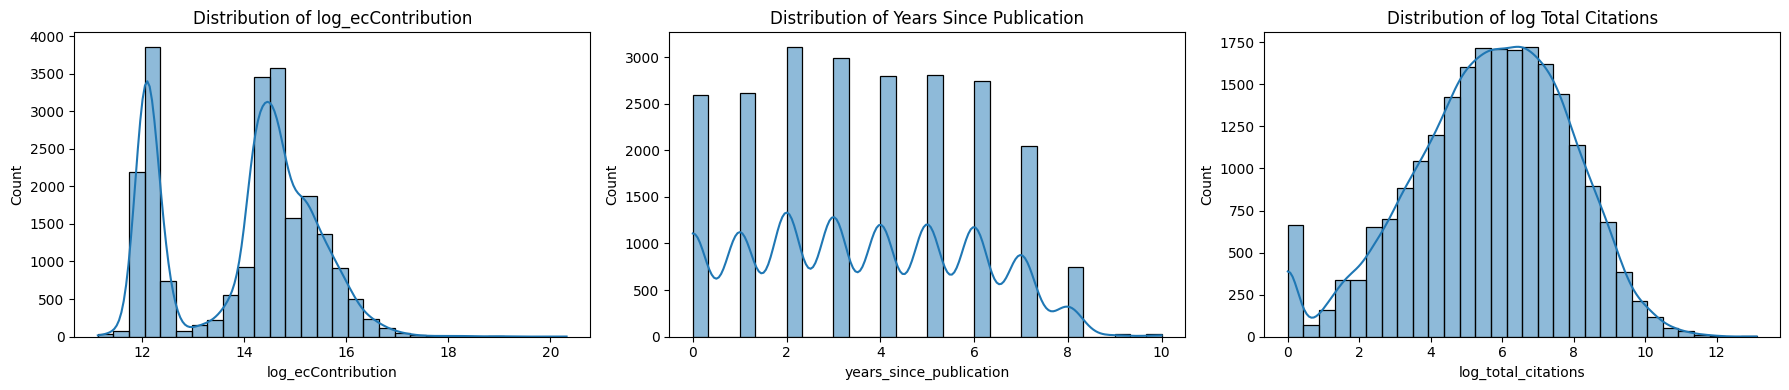

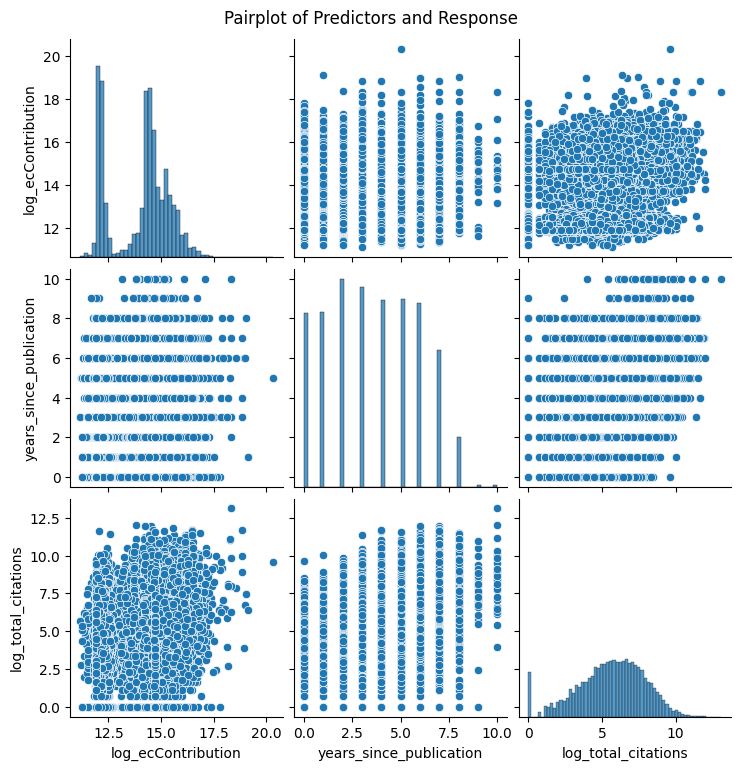

Correlation matrix:
                         log_ecContribution  years_since_publication  \
log_ecContribution                 1.000000                 0.022640   
years_since_publication            0.022640                 1.000000   
total_citations                    0.146485                 0.261327   

                         total_citations  
log_ecContribution              0.146485  
years_since_publication         0.261327  
total_citations                 1.000000  


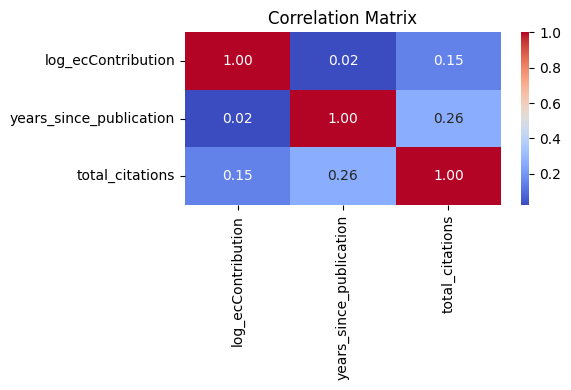

In [71]:
df = df_reg.copy()
# Use the filtered regression dataset
# Remove outliers
outliers = df[(df['years_since_publication'] > 10)]
df = df[~df['projectID'].isin(outliers['projectID'])]
df = df.reset_index(drop=True)

# Calculate 95th percentiles
# Add log-transformed columns (log1p handles zeros)
df['log_total_citations'] = np.log1p(df['total_citations'])
df['log_ecContribution'] = np.log1p(df['ecContribution'])


#cit95 = df_reg['total_citations'].quantile(0.95)
#fund95 = df_reg['ecContribution'].quantile(0.95)
#year95 = df_reg['years_since_publication'].quantile(0.95)

# Filter out rows above any of these thresholds
#df_reg_filtered = df_reg[
#    (df_reg['total_citations'] <= cit95) &
#    (df_reg['ecContribution'] <= fund95) &
#    (df_reg['years_since_publication'] <= year95)
#].copy()

  # Should already be defined as in previous cells

# 1. Summary statistics for numerical predictors and response
print("Summary statistics:")
print(df[['log_ecContribution', 'years_since_publication', 'log_total_citations']].describe())

# 2. Histograms for each numerical variable
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['log_ecContribution'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of log_ecContribution')
axes[0].set_xlabel('log_ecContribution')

sns.histplot(df['years_since_publication'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Years Since Publication')
axes[1].set_xlabel('years_since_publication')

sns.histplot(df['log_total_citations'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribution of log Total Citations')
axes[2].set_xlabel('log_total_citations')

plt.tight_layout()
plt.show()

# 3. Pairplot for numerical variables (scatterplots + histograms)
sns.pairplot(df[['log_ecContribution', 'years_since_publication', 'log_total_citations']])
plt.suptitle('Pairplot of Predictors and Response', y=1.02)
plt.show()

# 4. Correlation matrix
corr = df[['log_ecContribution', 'years_since_publication', 'total_citations']].corr()
print("Correlation matrix:")
print(corr)

# 5. Heatmap of correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

df.to_csv("../data/regression_dataset.csv", index=False)

Intercept: -4.784818042396353
Coefficients:
cat__country_AM: 3.503
cat__country_AT: 3.002
cat__country_BE: 2.907
cat__country_BG: 3.053
cat__country_CH: 3.553
cat__country_CY: 2.833
cat__country_CZ: 3.332
cat__country_DE: 3.192
cat__country_DK: 3.258
cat__country_EE: 3.321
cat__country_EL: 2.627
cat__country_ES: 2.980
cat__country_FI: 3.213
cat__country_FO: 2.322
cat__country_FR: 2.916
cat__country_GE: 0.816
cat__country_GL: 4.491
cat__country_HR: 3.035
cat__country_HU: 3.065
cat__country_IE: 2.890
cat__country_IL: 2.942
cat__country_IS: 2.787
cat__country_IT: 3.024
cat__country_LT: 2.662
cat__country_LU: 2.868
cat__country_LV: 3.443
cat__country_MD: 3.621
cat__country_ME: 1.524
cat__country_MT: 2.972
cat__country_NC: 0.614
cat__country_NL: 3.201
cat__country_NO: 2.942
cat__country_PL: 2.677
cat__country_PT: 2.971
cat__country_RO: 2.278
cat__country_RS: 3.164
cat__country_SE: 3.357
cat__country_SI: 3.015
cat__country_SK: 2.993
cat__country_TN: 2.901
cat__country_TR: 2.649
cat__country_

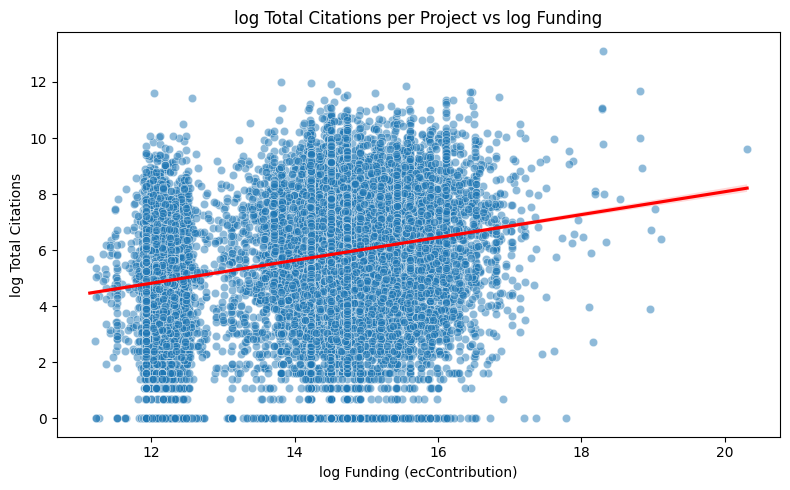

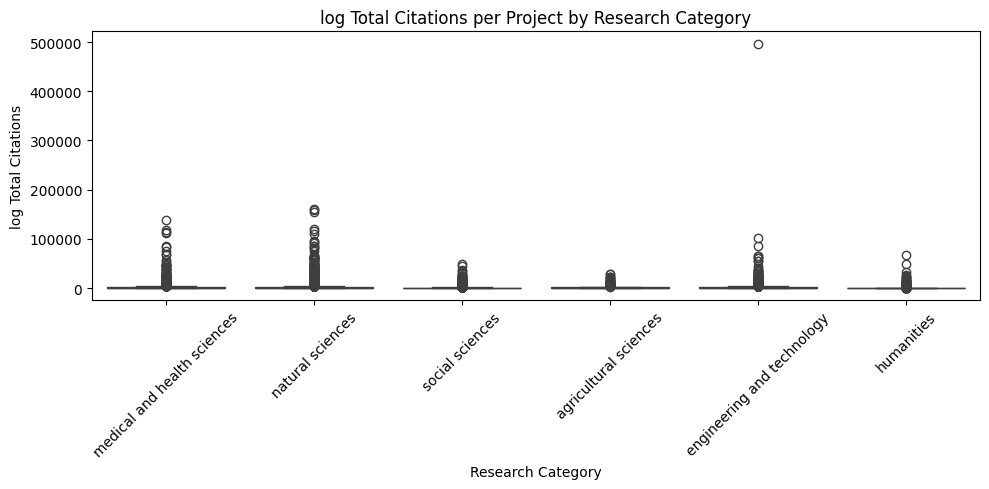

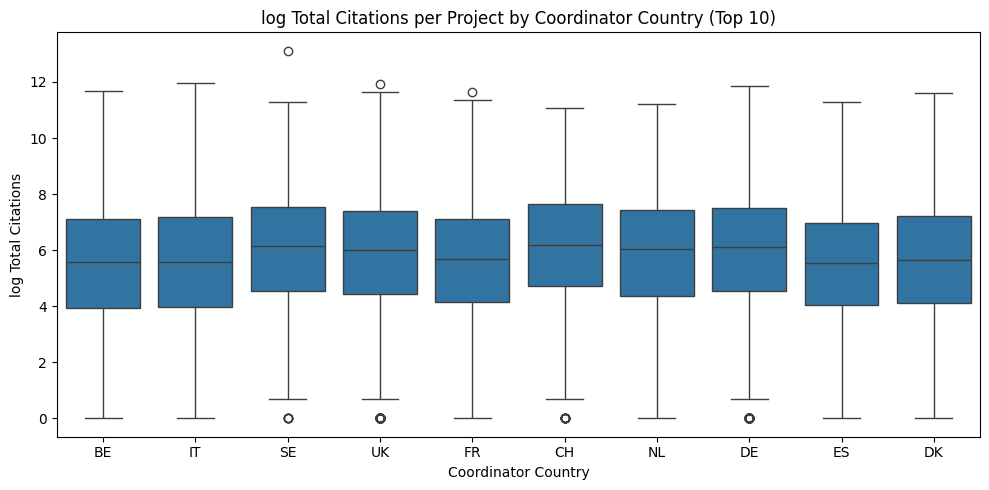

In [72]:

# 3. Prepare features and response
X = df[['log_ecContribution', 'country', 'category', 'years_since_publication']]
y = df['log_total_citations']

# 4. Build regression pipeline with one-hot encoding for categorical variables
categorical_features = ['country', 'category']
numeric_features = ['log_ecContribution', 'years_since_publication']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

reg_pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])

# 5. Fit model
reg_pipe.fit(X, y)

# 6. ANOVA-like summary: show coefficients
feature_names = reg_pipe.named_steps['pre'].get_feature_names_out()
coefs = reg_pipe.named_steps['reg'].coef_
intercept = reg_pipe.named_steps['reg'].intercept_

print("Intercept:", intercept)
print("Coefficients:")
for name, coef in zip(feature_names, coefs):
    print(f"{name}: {coef:.3f}")

# 7. Plot: Citations vs Funding with regression line
plt.figure(figsize=(8, 5))
sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=df, alpha=0.5)
sns.regplot(x='log_ecContribution', y='log_total_citations', data=df, scatter=False, color='red')
plt.title('log Total Citations per Project vs log Funding')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()

# 8. Plot: Citations by Research Category (boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='total_citations', data=df)
plt.title('log Total Citations per Project by Research Category')
plt.xlabel('Research Category')
plt.ylabel('log Total Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Plot: Citations by Coordinator Country (top 10 countries)
top_countries = df['country'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(x='country', y='log_total_citations', data=df[df['country'].isin(top_countries)])
plt.title('log Total Citations per Project by Coordinator Country (Top 10)')
plt.xlabel('Coordinator Country')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()

In [74]:
# Prepare dropdown options
topic_options = sorted(df['category'].dropna().unique())
country_options = sorted(df['country'].dropna().unique())

dropdown_topic = Dropdown(
    options=topic_options,
    value=topic_options[0],
    description='Research Topic:'
)
dropdown_country = Dropdown(
    options=country_options,
    value=country_options[0],
    description='Coordinator Country:'
)
out_funding_citations = Output()

def plot_funding_vs_citations(topic, country):
    data = df[(df['category'] == topic) & (df['country'] == country)]
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=data, alpha=0.6)
    if not data.empty:
        sns.regplot(x='log_ecContribution', y='log_total_citations', data=data, scatter=False, color='red')
    plt.title(f'log Citations vs log Funding\n{topic} / {country}')
    plt.xlabel('Funding (log_ecContribution)')
    plt.ylabel('log Total Citations')
    plt.tight_layout()
    plt.show()

def update_plot(change=None):
    with out_funding_citations:
        out_funding_citations.clear_output(wait=True)
        plot_funding_vs_citations(dropdown_topic.value, dropdown_country.value)

dropdown_topic.observe(update_plot, names='value')
dropdown_country.observe(update_plot, names='value')

display(VBox([dropdown_topic, dropdown_country, out_funding_citations]))
update_plot()

In [75]:
# 1. Model fit metrics (R^2, RMSE) on training data
y_pred = reg_pipe.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"R^2 (training): {r2:.3f}")
print(f"RMSE (training): {rmse:.2f}")

# 2. Statistical significance of coefficients using statsmodels
# Prepare design matrix with one-hot encoding (same as pipeline)
X_enc = reg_pipe.named_steps['pre'].transform(X)
X_enc = np.asarray(X_enc).astype(float)
X_enc = sm.add_constant(X_enc)
model = sm.OLS(y, X_enc)
results = model.fit()

# Print summary table (coefficients, std err, t, p-values)
feature_names_full = ['Intercept'] + list(feature_names)
summary_df = (
    pd.DataFrame({
        'feature': feature_names_full,
        'coef': results.params,
        'std_err': results.bse,
        't': results.tvalues,
        'p_value': results.pvalues
    })
)
print(summary_df)

# Show which coefficients are significant at alpha=0.05
significant = summary_df[summary_df['p_value'] < 0.05]
print("\nSignificant predictors (p < 0.05):")
print(significant[['feature', 'coef', 'p_value']])

# Optionally, display full statsmodels summary
display(results.summary())

R^2 (training): 0.416
RMSE (training): 1.70
                                         feature      coef   std_err  \
const                                  Intercept -4.784818  1.709235   
x1                               cat__country_AM  3.502518  1.967680   
x2                               cat__country_AT  3.001778  1.705529   
x3                               cat__country_BE  2.906840  1.705109   
x4                               cat__country_BG  3.052965  1.739362   
x5                               cat__country_CH  3.552669  1.705140   
x6                               cat__country_CY  2.833030  1.713358   
x7                               cat__country_CZ  3.331971  1.709857   
x8                               cat__country_DE  3.191921  1.704528   
x9                               cat__country_DK  3.258068  1.705330   
x10                              cat__country_EE  3.321212  1.717011   
x11                              cat__country_EL  2.626565  1.705746   
x12                 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_total_citations   R-squared:                       0.416
Model:                             OLS   Adj. R-squared:                  0.414
Method:                  Least Squares   F-statistic:                     319.9
Date:                 Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                         17:14:20   Log-Likelihood:                -43939.
No. Observations:                22528   AIC:                         8.798e+04
Df Residuals:                    22477   BIC:                         8.839e+04
Df Model:                           50                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7848      1.709     -2.799      0.005      -8.135      -1.435
x1             3.5025      1.968      1.780      0.075      -0.354       7.359
x2             3.0018      1.706      1.760      0.078      -0.341       6.345
x3             2.9068      1.705      1.705      0.088      -0.435       6.249
x4             3.0530      1.739      1.755      0.079      -0.356       6.462
x5             3.5527      1.705      2.084      0.037       0.210       6.895
x6             2.8330      1.713      1.653      0.098      -0.525       6.191
x7             3.3320      1.710      1.949      0.051      -0.019       6.683
x8             3.1919      1.705      1.873      0.061      -0.149       6.533
x9             3.2581      1.705      1.911      0.056      -0.084       6.601
x10            3.3212      1.717      1.934      0.053      -0.044       6.687
x11            2.6266      1.706      1.540      0.124      -0.717       5.970
x12            2.9797      1.705      1.748      0.080      -0.361       6.321
x13            3.2128      1.706      1.883      0.060      -0.131       6.557
x14            2.3223      2.411      0.963      0.335      -2.403       7.048
x15            2.9162      1.705      1.711      0.087      -0.425       6.257
x16            0.8161      2.410      0.339      0.735      -3.907       5.539
x17            4.4914      2.410      1.864      0.062      -0.232       9.214
x18            3.0348      1.741      1.743      0.081      -0.377       6.447
x19            3.0646      1.716      1.786      0.074      -0.299       6.428
x20            2.8903      1.706      1.694      0.090      -0.454       6.234
x21            2.9422      1.706      1.725      0.085      -0.402       6.286
x22            2.7873      1.732      1.609      0.108      -0.608       6.183
x23            3.0238      1.705      1.774      0.076      -0.317       6.365
x24            2.6618      1.737      1.533      0.125      -0.742       6.066
x25            2.8682      1.718      1.670      0.095      -0.499       6.235
x26            3.4429      1.764      1.952      0.051      -0.015       6.900
x27            3.6214      2.410      1.503      0.133      -1.102       8.345
x28            1.5240      2.411      0.632      0.527      -3.202       6.249
x29            2.9721      1.760      1.689      0.091      -0.478       6.422
x30            0.6144      2.411      0.255      0.799      -4.111       5.340
x31            3.2007      1.705      1.878      0.060      -0.141       6.542
x32            2.9424      1.706      1.725      0.085      -0.402       6.286
x33            2.6772      1.711      1.565      0.118      -0.676       6.030
x34            2.9708      1.706      1.741      0.082      -0.374       6.315
x35            2.2783      1.725      1.321      0.187      -1.103    

Intercept (no country): -1.6343927131238871
Coefficients (no country):
cat__category_engineering and technology: -0.200
cat__category_humanities: -1.437
cat__category_medical and health sciences: 0.346
cat__category_natural sciences: 0.221
cat__category_social sciences: -0.595
num__log_ecContribution: 0.389
num__years_since_publication: 0.519
                                         feature      coef   std_err  \
const                                  Intercept -1.634393  0.141808   
x1      cat__category_engineering and technology -0.199640  0.082454   
x2                      cat__category_humanities -1.437262  0.093828   
x3     cat__category_medical and health sciences  0.346033  0.084674   
x4                cat__category_natural sciences  0.220817  0.080239   
x5                 cat__category_social sciences -0.595375  0.085079   
x6                       num__log_ecContribution  0.389496  0.008322   
x7                  num__years_since_publication  0.518927  0.004904   

      

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_total_citations   R-squared:                       0.409
Model:                             OLS   Adj. R-squared:                  0.409
Method:                  Least Squares   F-statistic:                     2224.
Date:                 Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                         17:14:26   Log-Likelihood:                -44074.
No. Observations:                22528   AIC:                         8.816e+04
Df Residuals:                    22520   BIC:                         8.823e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6344      0.142    -11.525      0.000      -1.912      -1.356
x1            -0.1996      0.082     -2.421      0.015      -0.361      -0.038
x2            -1.4373      0.094    -15.318      0.000      -1.621      -1.253
x3             0.3460      0.085      4.087      0.000       0.180       0.512
x4             0.2208      0.080      2.752      0.006       0.064       0.378
x5            -0.5954      0.085     -6.998      0.000      -0.762      -0.429
x6             0.3895      0.008     46.806      0.000       0.373       0.406
x7             0.5189      0.005    105.807      0.000       0.509       0.529
==============================================================================
Omnibus:                     1546.930   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2053.775
Skew:                          -0.618   Prob(JB):                         0.00
Kurtosis:                       3.813   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

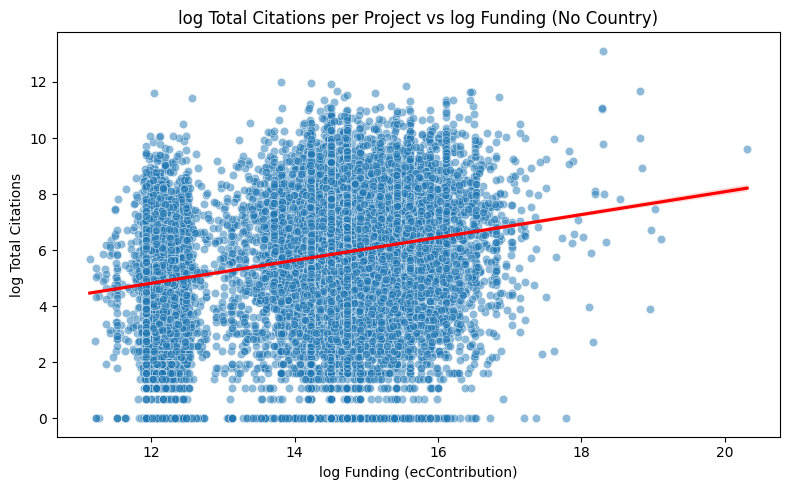

In [76]:
# Prepare features and response (exclude 'country')
X_no_country = df[['log_ecContribution', 'category', 'years_since_publication']]
y = df['log_total_citations']

# Pipeline: one-hot encode 'category', passthrough numerics
preprocessor_no_country = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['category']),
        ('num', 'passthrough', ['log_ecContribution', 'years_since_publication'])
    ]
)

reg_pipe_no_country = Pipeline([
    ('pre', preprocessor_no_country),
    ('reg', LinearRegression())
])

# Fit model
reg_pipe_no_country.fit(X_no_country, y)

# Coefficient names and values
feature_names_nc = reg_pipe_no_country.named_steps['pre'].get_feature_names_out()
coefs_nc = reg_pipe_no_country.named_steps['reg'].coef_
intercept_nc = reg_pipe_no_country.named_steps['reg'].intercept_

print("Intercept (no country):", intercept_nc)
print("Coefficients (no country):")
for name, coef in zip(feature_names_nc, coefs_nc):
    print(f"{name}: {coef:.3f}")

# Statistical significance with statsmodels
X_enc_nc = reg_pipe_no_country.named_steps['pre'].transform(X_no_country)
X_enc_nc = np.asarray(X_enc_nc).astype(float)
X_enc_nc = sm.add_constant(X_enc_nc)
model_nc = sm.OLS(y, X_enc_nc)
results_nc = model_nc.fit()

# Print summary table (coefficients, std err, t, p-values)
feature_names_full_nc = ['Intercept'] + list(feature_names_nc)
summary_df_nc = (
    pd.DataFrame({
        'feature': feature_names_full_nc,
        'coef': results_nc.params,
        'std_err': results_nc.bse,
        't': results_nc.tvalues,
        'p_value': results_nc.pvalues
    })
)
print(summary_df_nc)

# Show significant predictors
significant_nc = summary_df_nc[summary_df_nc['p_value'] < 0.05]
print("\nSignificant predictors (p < 0.05):")
print(significant_nc[['feature', 'coef', 'p_value']])

# Optionally, display full statsmodels summary
display(results_nc.summary())

# Plot: Citations vs Funding with regression line (no country)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=df, alpha=0.5)
sns.regplot(x='log_ecContribution', y='log_total_citations', data=df, scatter=False, color='red')
plt.title('log Total Citations per Project vs log Funding (No Country)')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()



In [77]:
# Dropdown for research category
category_options = sorted(df['category'].dropna().unique())
dropdown_cat = Dropdown(
    options=category_options,
    value=category_options[0],
    description='Category:'
)
out_plot = Output()

def plot_scatter_regression(selected_cat):
    subset = df[df['category'] == selected_cat]
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=subset, alpha=0.6)
    if not subset.empty:
        sns.regplot(
            x='log_ecContribution',
            y='log_total_citations',
            data=subset,
            scatter=False,
            color='red',
            label='Regression line'
        )
    plt.title(f'log Total Citations vs log Funding\nCategory: {selected_cat}')
    plt.xlabel('log Funding (ecContribution)')
    plt.ylabel('log Total Citations')
    plt.tight_layout()
    plt.show()

def update_plot(change=None):
    with out_plot:
        out_plot.clear_output(wait=True)
        plot_scatter_regression(dropdown_cat.value)

dropdown_cat.observe(update_plot, names='value')

display(VBox([dropdown_cat, out_plot]))
update_plot()

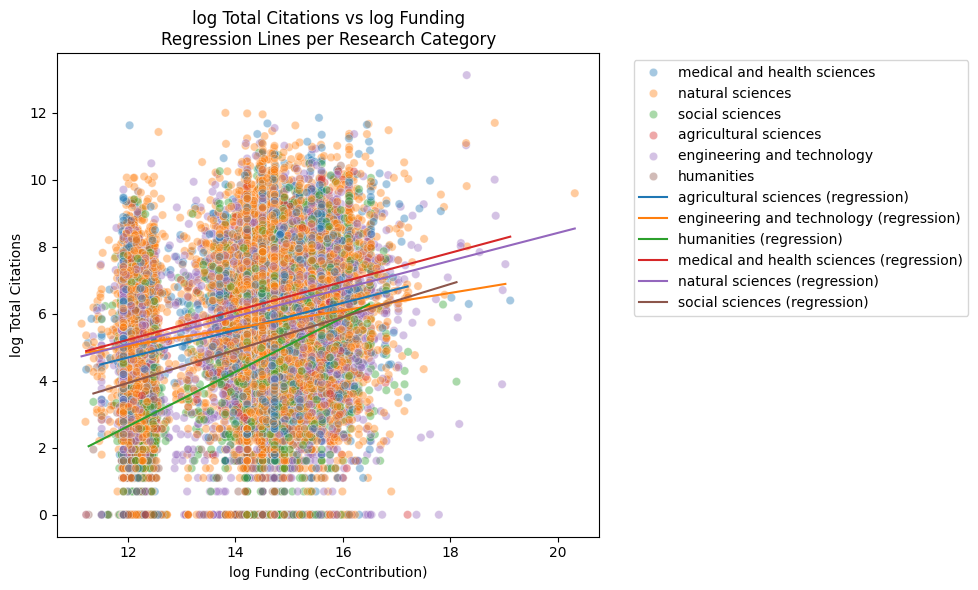

In [78]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(category_options))

# Scatter all points, colored by category
sns.scatterplot(
    x='log_ecContribution',
    y='log_total_citations',
    hue='category',
    data=df,
    alpha=0.4,
    palette=palette,
    legend='full'
)

# Plot regression line for each category
for i, cat in enumerate(category_options):
    subset = df[df['category'] == cat]
    if len(subset) > 1:
        # Fit linear regression for this category
        x = subset['log_ecContribution']
        y = subset['log_total_citations']
        coef = np.polyfit(x, y, 1)
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = coef[0] * x_vals + coef[1]
        plt.plot(x_vals, y_vals, color=palette[i], label=f"{cat} (regression)")

plt.title('log Total Citations vs log Funding\nRegression Lines per Research Category')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

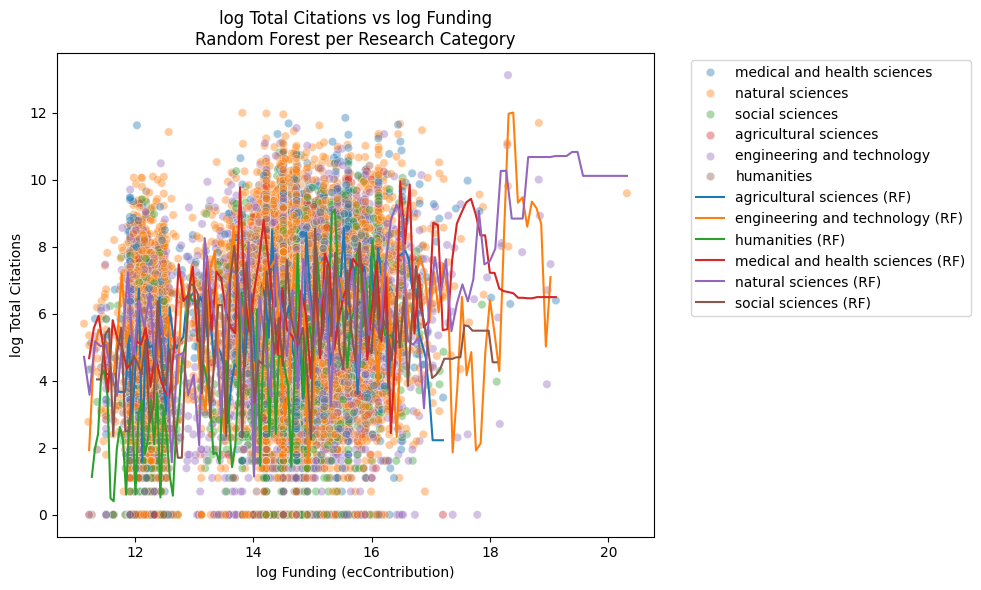

In [79]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(category_options))

sns.scatterplot(
    x='log_ecContribution',
    y='log_total_citations',
    hue='category',
    data=df,
    alpha=0.4,
    palette=palette,
    legend='full'
)

for i, cat in enumerate(category_options):
    subset = df[df['category'] == cat]
    if len(subset) > 10:  # Need enough data for ML
        X = subset[['log_ecContribution']].values
        y = subset['log_total_citations'].values
        # Fit Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_vals)
        plt.plot(x_vals, y_pred, color=palette[i], label=f"{cat} (RF)")

plt.title('log Total Citations vs log Funding\nRandom Forest per Research Category')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()